min max
[-7.2121620e-04  1.6392209e-05] [1.0022331 1.0000378]
3.15M Parameters


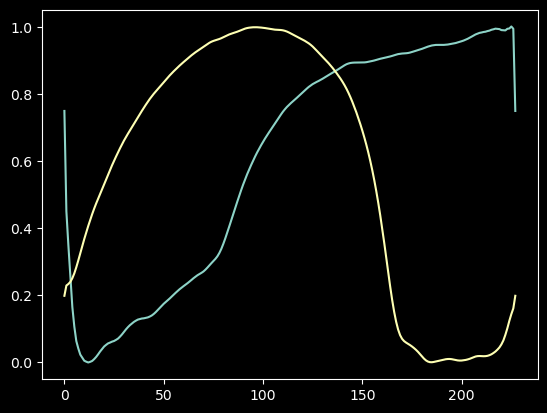

In [3]:
PATH = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/"
from modules.learning.models import *
from modules.learning.train import train_model
from modules.utils import hc
from modules.visualize import plot_loss, plot_normalized_time_error

# from modules.learning.evaluate import Evaluation, get_latent_space, plot_umap
from matplotlib import pyplot as plt
from modules.learning.dycep import DYCEP
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# enet = EfficientNet()
model = DYCEP()
model.to(DEVICE)

track_path = PATH + "track_datasets/control_mm/train/images/"
label_path = PATH + "track_datasets/control_mm/train/labels/"

#########
# test on one track
#########

track_name = "0607.1629.npy"
# getting one sequence to check the model
imgs = torch.tensor(
    np.load(track_path + track_name, allow_pickle=True),
    dtype=torch.float32,
)[:, [2], :, :]


label = torch.tensor(
    np.load(label_path + track_name).reshape(2, -1).T,
    dtype=torch.float32,
)

imgs, label = imgs.to(DEVICE), label.to(DEVICE)

zz = model.forward(imgs[None, :, :, :])
zz = zz.detach().cpu().numpy().squeeze()
plt.plot(zz)
print("min max")
print(zz.min(0), zz.max(0))
print(hc(model), "Parameters")

In [16]:
zz.shape

torch.Size([1, 228, 2])

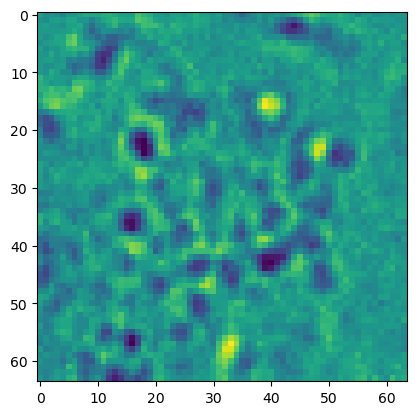

In [2]:
imgs.shape
imgs = torch.tensor(
    np.load(track_path + track_name, allow_pickle=True),
    dtype=torch.float32,
)[:, :, :, :]

plt.imshow(imgs[10, 1, :, :].detach().cpu().numpy())

In [4]:
train_model(
    directory=PATH + "track_datasets/control_mm/",
    model=model,
    # pass [1] for only BF channel, or [1,1,1] for 3 times the same channel
    # or [0,1,2] for all channels
    img_channels=[1],
    batch_size=1,
    learning_rate=1e-4,
    slice_p=0,
    name="DYCEP",
    num_epochs=5,
)

Epoch 1/5


100%|██████████| 358/358 [00:08<00:00, 41.68it/s]


    Train Loss: 0.014, Test Loss: 0.019
    Train R2: 0.893, Test R2: 0.896
Epoch 2/5


100%|██████████| 358/358 [00:06<00:00, 54.79it/s]


    Train Loss: 0.012, Test Loss: 0.017
    Train R2: 0.899, Test R2: 0.900
Epoch 3/5


100%|██████████| 358/358 [00:06<00:00, 55.20it/s]


    Train Loss: 0.011, Test Loss: 0.018
    Train R2: 0.903, Test R2: 0.905
Epoch 4/5


100%|██████████| 358/358 [00:05<00:00, 64.81it/s]


    Train Loss: 0.009, Test Loss: 0.017
    Train R2: 0.908, Test R2: 0.909
Epoch 5/5


100%|██████████| 358/358 [00:06<00:00, 54.43it/s]

    Train Loss: 0.008, Test Loss: 0.017
    Train R2: 0.912, Test R2: 0.914


'Done!'

dict_keys(['number', 'path', 'name', 'model_type', 'img_channels', 'batch_size', 'num_epochs', 'learning_rate', 'train_loss', 'test_loss', 'train_R2', 'test_R2'])


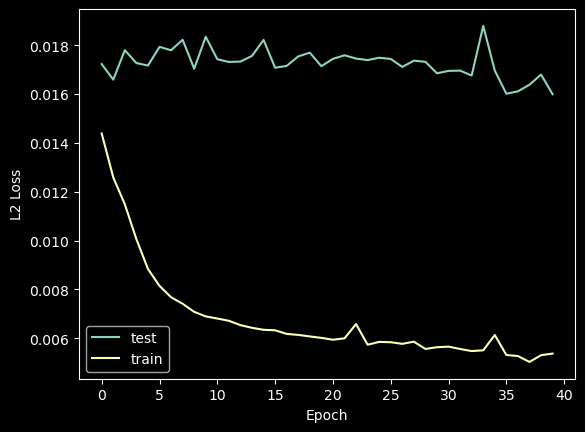

In [9]:
conf_path = "weights/config-22.json"

# load dict in .json file
with open(conf_path, "r") as file:
    config = json.load(file)

config["train_loss"]
config["test_loss"]

print(config.keys())
plt.plot(config["test_loss"], label="test")
plt.plot(config["train_loss"], label="train")

plt.ylabel("L2 Loss")
plt.xlabel("Epoch")

plt.legend()

In [10]:
from modules.learning.evaluate import Evaluation


model.load_state_dict(torch.load("weights/model-20.pt"))

eval = Evaluation()
eval.fit(
    PATH + "track_datasets/control_mm/test/", model, img_channels=[0], smoothing=True
)

2024-12-02 11:07:15.126390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 11:07:15.956471: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|██████████| 358/358 [00:16<00:00, 22.30it/s]


----------------------------------------------------------------------
Model Performance:
\ell_1: 0.116 ± 0.043
\ell_2: 0.033 ± 0.027
W_d: 0.086 ± 0.032
Accuracy: 0.762 ± 0.117



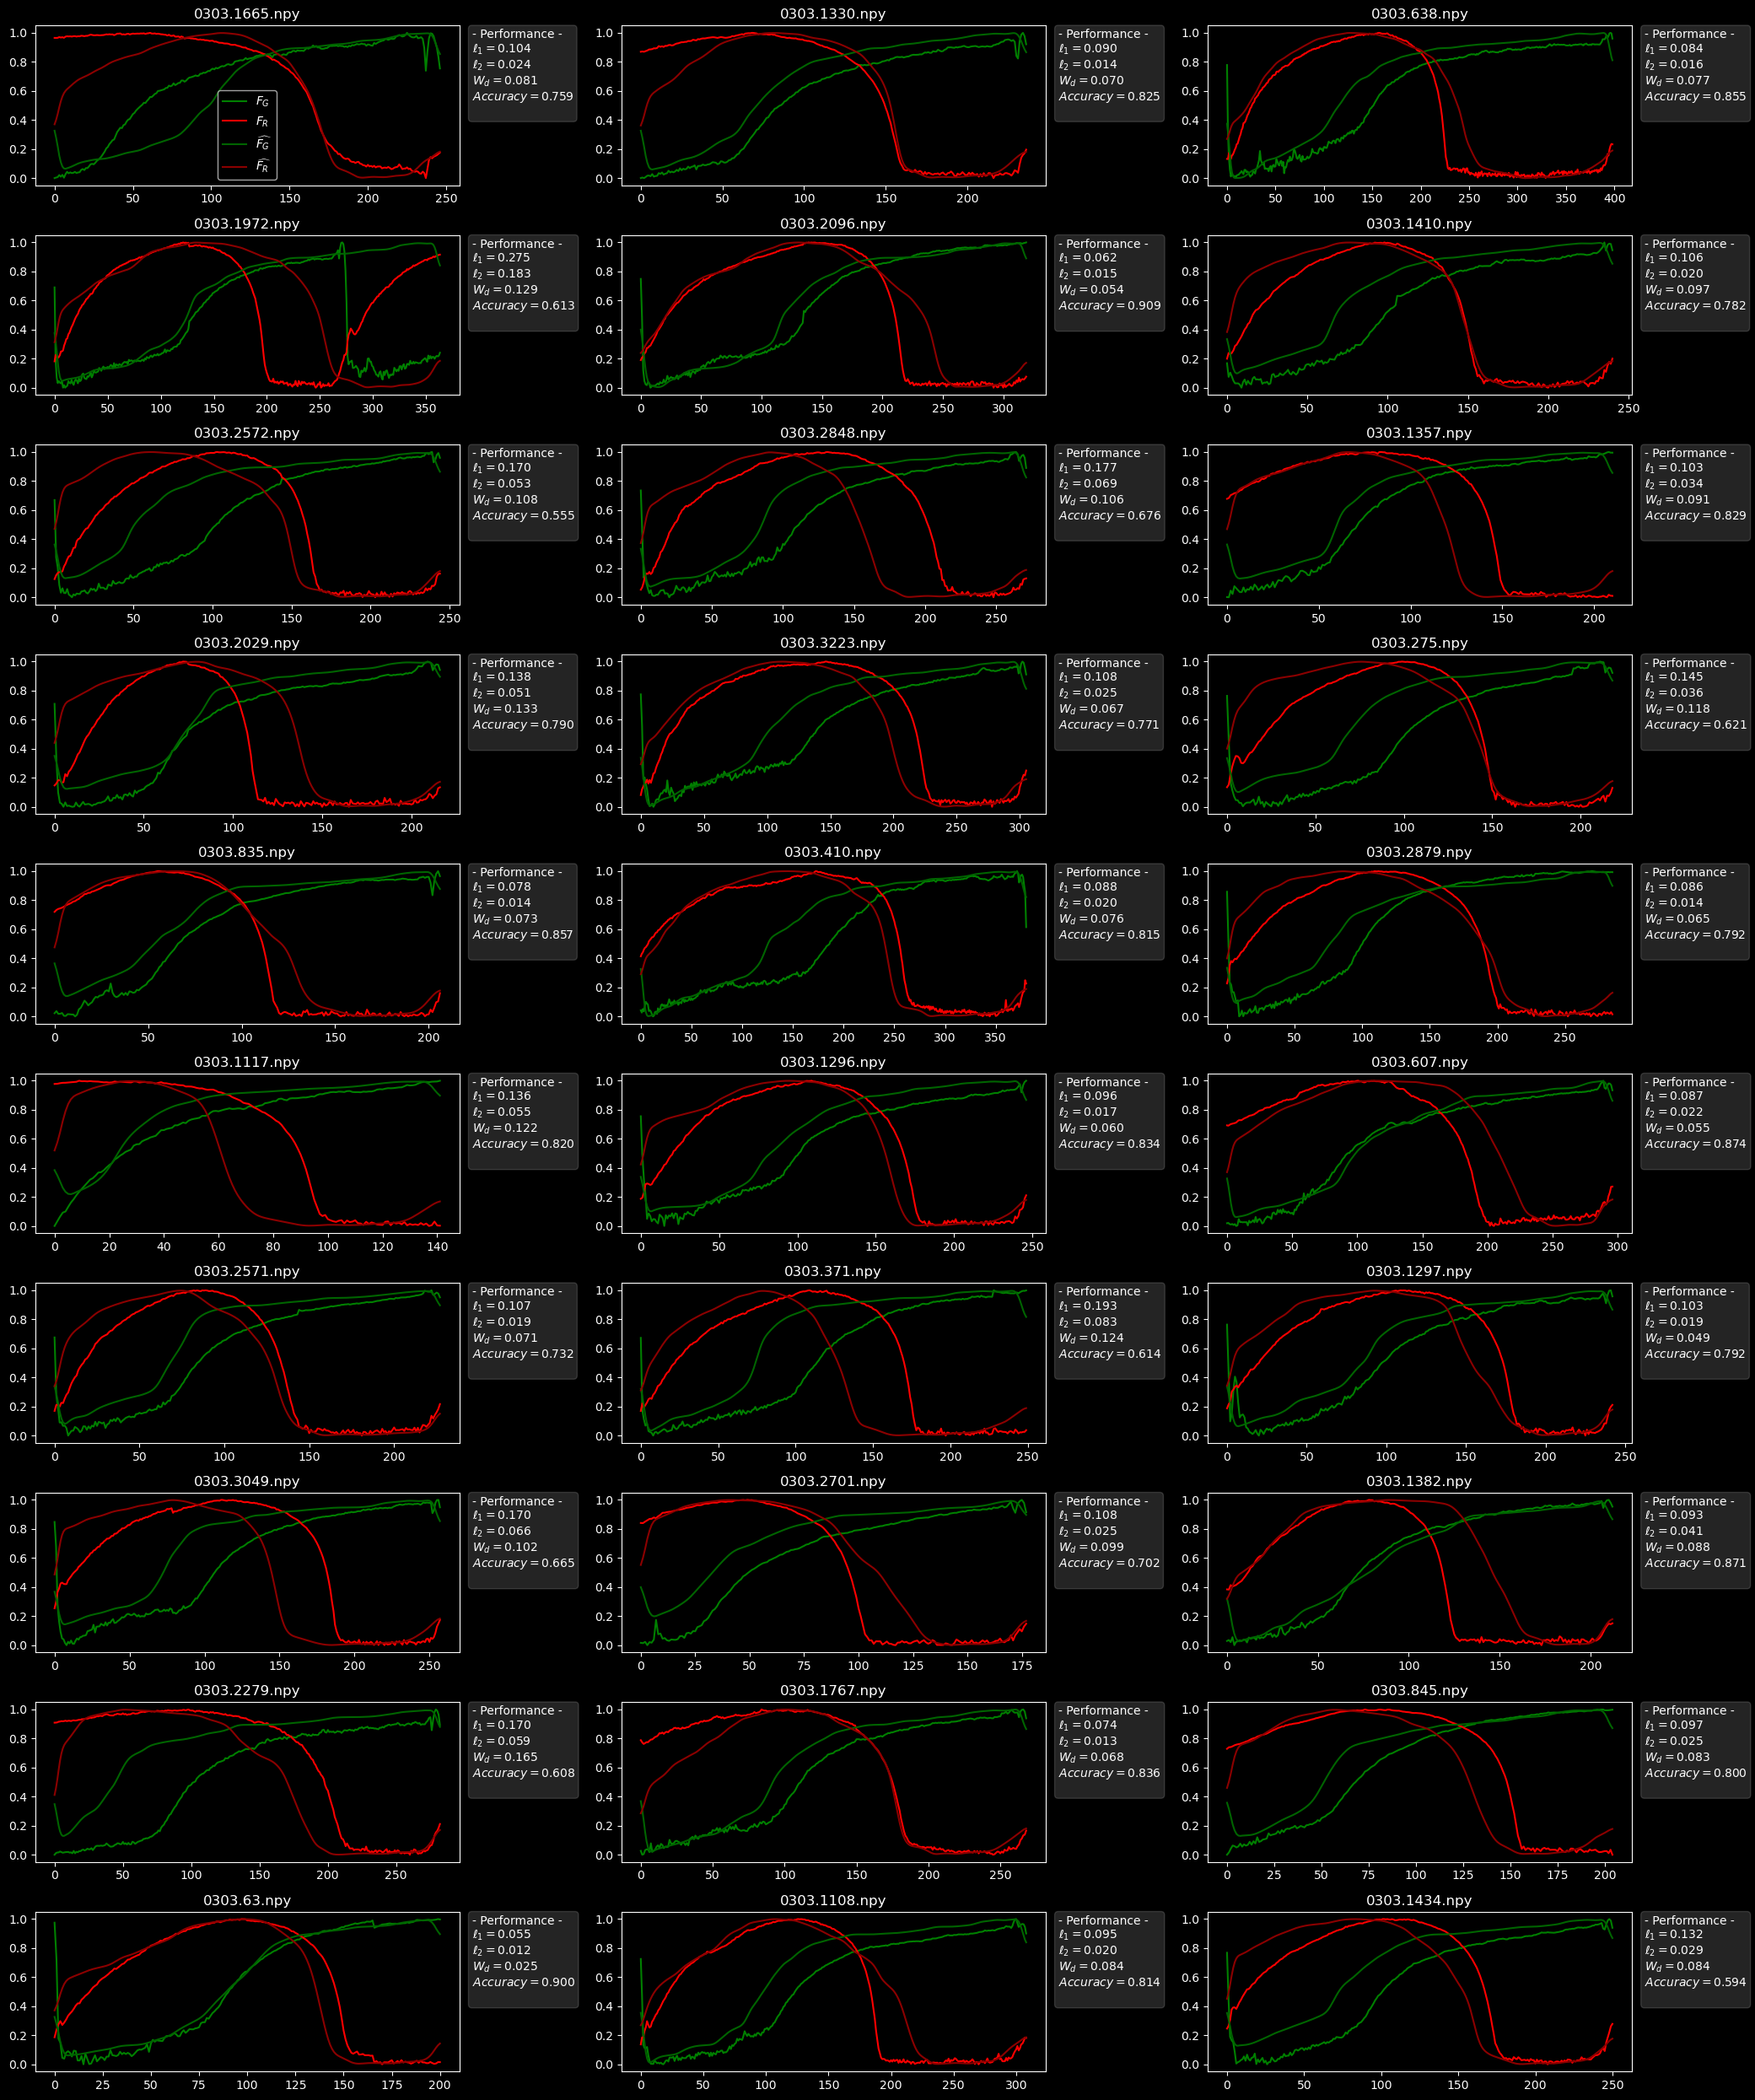

In [11]:
print(eval.summary())
eval.visualize_predicted_tracks(30)

In [28]:
eval.prediction_df.columns


Index(['CELL_ID', 'y', 'y_hat', '\ell_1', '\ell_2', 'W_d', 'Accuracy'], dtype='object')

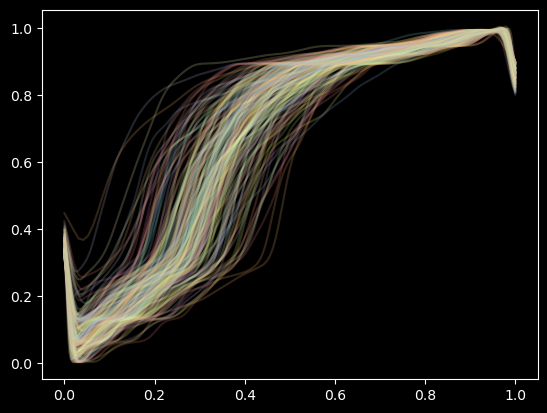

In [12]:
for i in range(200):
    track = eval.prediction_df.y_hat[i]
    tau = np.linspace(0, 1, track.shape[0])
    plt.plot(tau, track[:, 0], alpha=0.2)

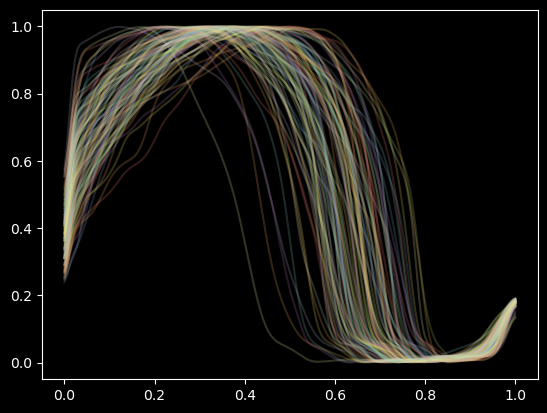

In [9]:
for i in range(100):
    track = eval.prediction_df.y_hat[i]
    tau = np.linspace(0, 1, track.shape[0])
    plt.plot(tau, track[:, 1], alpha=0.2)

# get phases

In [13]:
import os
from tqdm import tqdm

In [ ]:
img_directory = PATH + "track_datasets/control_mm/test/images/"
cells = os.listdir(img_directory)[:]
# Initialize pandas cells so we can store tracks inside
# model.to(DEVICE)

ph = []
for idx, cell in enumerate(tqdm(cells)):
    # Get input with specific image channels and groundtruth FUCCI signal
    x = (
        torch.tensor(
            np.load(img_directory + cell, allow_pickle=True),
            dtype=torch.float32,
        )[:, [1], :, :]
        .unsqueeze(0)
        .to(DEVICE)
    )

    x = model.spatial_encoder(x)
    x = model.temporal_encoder(model.fc_s2t(x))
    x = model.get_phi(x)

    ph.append(x.detach().cpu().numpy().squeeze())

100%|██████████| 358/358 [00:05<00:00, 62.06it/s]


Text(0.5, 0, 'Normalized Time')

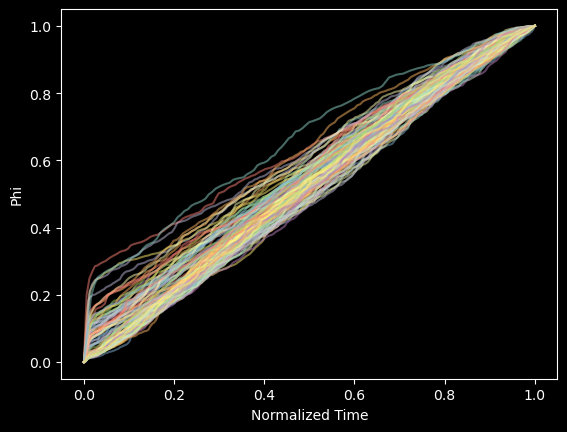

In [ ]:
for i in range(100):
    plt.plot(np.linspace(0, 1, len(ph[i])), ph[i], alpha=0.5)

plt.ylabel("Phi")
plt.xlabel("Normalized Time")